HEATMAP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import seaborn as sns
import os

In [3]:
df = pd.read_csv('/home/l2brb/main/DECpietro/evaluation/conformance/clustering/bpic15.csv', header=0, delimiter='\t')
#print(df.head())


Clustering on fitness values

In [4]:
df_cluster = df[df.iloc[:, 10] != 1]
trace_fitness = df_cluster.iloc[:, 10].values.reshape(-1, 1)
Z = linkage(trace_fitness, method='ward')
clusters = fcluster(Z, t=5, criterion='maxclust')
df_cluster['Cluster'] = clusters


/tmp/ipykernel_6071/137243933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Cluster'] = clusters


Dendrogram

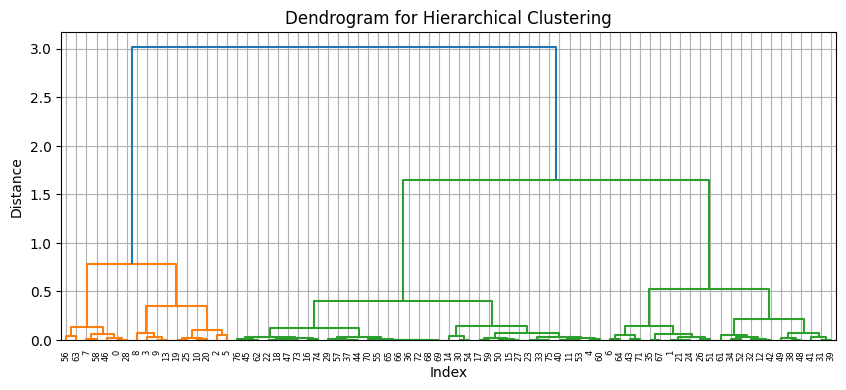

In [5]:
plt.figure(figsize=(10, 4))
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Index")
plt.ylabel("Distance")
dendrogram(Z)
plt.grid()
plt.show()

In [6]:
df_subset = df_cluster.iloc[:, [0, 10, 15]]
df_subset.columns = ['Constraint', 'Fitness', 'Cluster']
df_subset.to_csv('/home/l2brb/main/DECpietro/evaluation/conformance/clustering/df_subset.csv', index=False)

print(df_subset)

                                            Constraint  Fitness  Cluster
0    'AlternatePrecedence(01_HOOFD_515, {01_BB_540,...    0.059        1
2    'AlternatePrecedence(01_HOOFD_810, {01_BB_540,...    0.699        4
5    'AlternatePrecedence(01_HOOFD_010, {01_HOOFD_0...    0.343        2
6    'AlternatePrecedence(01_HOOFD_010, {01_HOOFD_0...    0.245        2
7    'AlternatePrecedence(01_HOOFD_011, 01_HOOFD_015)'    0.901        3
..                                                 ...      ...      ...
118  'AlternatePrecedence({01_HOOFD_480, 08_AWB45_0...    0.997        3
119  'AlternatePrecedence({01_HOOFD_480, 08_AWB45_0...    0.956        3
120  'AlternatePrecedence({01_HOOFD_490_1, 08_AWB45...    0.970        3
121  'AlternatePrecedence({01_HOOFD_490_1, 08_AWB45...    0.916        3
124    'AlternatePrecedence(05_EIND_010, 16_LGSV_010)'    0.937        3

[77 rows x 3 columns]


PER AGGIUNGERE CLUSTER 0 OVVERO FITNES == 1 EDIT: DA AGGIORNARE CON GLI ID

In [445]:
# Estrai le righe da df in cui il valore della colonna Fitness (iloc[:, 10]) è 1
df_to_readd = df[df.iloc[:, 10] == 1].copy()

# Seleziona la colonna Constraint (iloc[:, 0]) e la colonna Fitness (iloc[:, 10])
df_to_readd = df_to_readd.iloc[:, [0, 10]].copy()
df_to_readd.columns = ['Constraint', 'Fitness']

# Assegna il cluster 0
df_to_readd['Cluster'] = 0

# Aggiungi queste righe al df_subset esistente
df_subset = pd.concat([df_subset, df_to_readd], ignore_index=True)
print(df_subset.head)

<bound method NDFrame.head of                                             Constraint  Fitness  Cluster
0    'AlternatePrecedence(01_HOOFD_515, {01_BB_540,...    0.059        1
1    'AlternatePrecedence(01_HOOFD_810, {01_BB_540,...    0.699        4
2    'AlternatePrecedence(01_HOOFD_010, {01_HOOFD_0...    0.343        2
3    'AlternatePrecedence(01_HOOFD_010, {01_HOOFD_0...    0.245        2
4    'AlternatePrecedence(01_HOOFD_011, 01_HOOFD_015)'    0.901        3
5    'AlternatePrecedence(01_HOOFD_020, {01_HOOFD_0...    0.390        2
6    'AlternatePrecedence({01_HOOFD_030_1, 04_BPT_0...    0.757        4
7    'AlternatePrecedence(04_BPT_005, {01_HOOFD_030...    0.018        1
8    'AlternatePrecedence(04_BPT_005, {01_HOOFD_030...    0.200        2
9    'AlternatePrecedence(01_HOOFD_030_2, {01_HOOFD...    0.268        2
10   'AlternatePrecedence(01_HOOFD_030_2, {01_HOOFD...    0.424        2
11   'AlternatePrecedence(01_HOOFD_040, 01_HOOFD_050)'    0.895        3
12   'AlternatePreced

In [8]:
# Calcola il valore medio della fitness per ciascun cluster
cluster_means = df_subset.groupby('Cluster')['Fitness'].mean().sort_values()

# Crea una mappatura: il cluster con fitness media più bassa sarà 1,
# il successivo 2, etc.
new_mapping = {old: new for new, old in enumerate(cluster_means.index, start=1)}

# Applica la mappatura per aggiornare la colonna "Cluster"
df_subset['Cluster'] = df_subset['Cluster'].map(new_mapping)

Constraint    'AlternatePrecedence(01_HOOFD_510_2, {01_HOOFD...
Fitness                                                   0.023
Cluster                                                       1
Name: 58, dtype: object


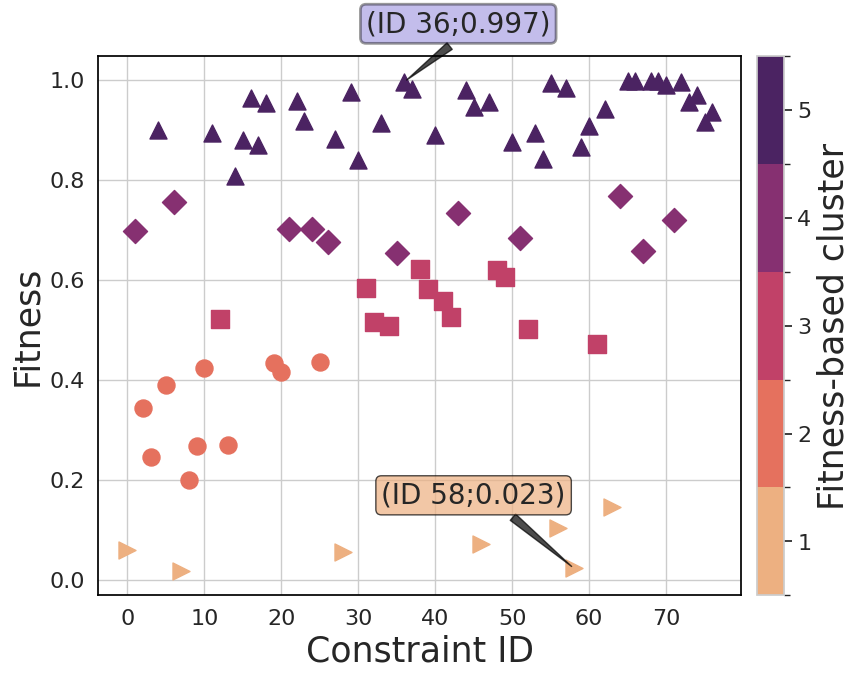

In [99]:
df_subset = df_subset.reset_index(drop=True)
cluster_ranges = df_subset.groupby('Cluster')['Fitness'].agg(['min','max'])


unique_clusters = np.sort(df_subset['Cluster'].unique())
#prev "flare"
#prev "crest"

cmap = plt.get_cmap("flare")
colors = [cmap((cl - unique_clusters.min())/(unique_clusters.max()-unique_clusters.min())) for cl in unique_clusters]


markers = ['>', 'o', 's', 'D', '^', 'v', 'P', 'X']  

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
#sns.set_theme()

for i, cl in enumerate(unique_clusters):
    marker = markers[i % len(markers)]
    ix = df_subset['Cluster'] == cl
    cl_min = cluster_ranges.loc[cl, 'min']
    cl_max = cluster_ranges.loc[cl, 'max']
    label = f"CL {cl}: {cl_min:.3f} - {cl_max:.3f}"
    plt.scatter(df_subset.index[ix], df_subset['Fitness'][ix], c=[colors[i]], label=label, s=150, marker=marker)


#plt.legend(title="Cluster", loc="lower right")
#plt.legend(title="Fitness Clusters", loc="upper left", bbox_to_anchor=(1.05, 1), ncol=1, prop={'size': 10})
plt.xlabel("Constraint ID", fontsize=25)
plt.ylabel("Fitness", fontsize=25)

# cb = plt.colorbar()
# cb.ax.invert_yaxis() 
# ticks = cb.get_ticks()          
# cb.set_ticks(ticks[::-1])


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)
#plt.tight_layout()

############################ COLORBAR ###########################################

unique_clusters = np.sort(df_subset['Cluster'].unique())

discrete_cmap = mcolors.ListedColormap(colors[:len(unique_clusters)])
bounds = np.arange(unique_clusters[0] - 0.5, unique_clusters[-1] + 1, 1)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(unique_clusters))

sm = cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

ax = plt.gca()
cb = plt.colorbar(sm, ticks=unique_clusters, ax=ax, pad=0.02)
cb.set_label("Fitness-based cluster", fontsize=25)

# Formatting colorbar ticks
cb.ax.set_yticklabels([str(c) for c in unique_clusters], fontsize=16)

# labels = [f"CL {cl}\nmin: {cluster_ranges.loc[cl, 'min']:.3f}" for cl in unique_clusters]
# cb.ax.set_yticklabels(labels)

############################ COLORBAR ###########################################

plt.savefig('/home/l2brb/main/DECpietro/evaluation/conformance/clustering/scatter.pdf',
            bbox_inches='tight', pad_inches=0.2)


#ADDING ANNOTATIONS 

selected_point = df_subset.iloc[36]
#print(selected_point)
x_val = selected_point.name     
y_val = selected_point['Fitness']

# Annotation ID 36
#plt.annotate(r"$\mathbf{Alt.Prec.}$" +"({t01_HOOFD_490_1,t13_CRD_010},t01_HOOFD_490_1a)}",
plt.annotate("(ID 36;0.997)",            
             xy=(x_val, y_val), 
             fontsize=20,  
             xytext=(x_val-5, y_val+0.10), 
             bbox=dict(boxstyle="round,pad=0.20", fc="slateblue", ec="black", lw=2, alpha=0.4),
             arrowprops=dict(arrowstyle="wedge", connectionstyle="arc3",
                             color="black", alpha=0.7, relpos=(0.51, 0))) #relpos=(0, 0.5))


selected_point = df_subset.iloc[58]
print(selected_point)
#print(selected_point)
x_val = selected_point.name    
y_val = selected_point['Fitness']

# Annotation ID 58
# plt.annotate(r"$\mathbf{Alt.Prec.}$" +"(t01_HOOFD_510_2, {t01_HOOFD_510_3, t01_HOOFD_520, tEND})",
plt.annotate("(ID 58;0.023)",
             xy=(x_val, y_val), 
             fontsize=20,  
             xytext=(x_val-25, y_val+0.13), 
             bbox=dict(boxstyle="round,pad=0.20", fc="#EDB081", ec="black", lw=1, alpha=0.7),
             arrowprops=dict(arrowstyle="wedge", connectionstyle="arc3",
                             color="black", alpha=0.7, relpos=(0.5, 0.9))) #relpos=(0, 0.5))


ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
plt.savefig('/home/l2brb/main/DECpietro/evaluation/conformance/clustering/scatter.pdf',
            bbox_inches='tight', pad_inches=0.15)
plt.show()



